In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_csv='/content/drive/MyDrive/E6691 Assignment2/sign_mnist_train.csv'
test_csv='/content/drive/MyDrive/E6691 Assignment2/sign_mnist_test.csv'

In [4]:
# Load training and testing set from the CSV files
f_train_csv=pd.read_csv(train_csv).values
f_test_csv=pd.read_csv(test_csv).values

In [5]:
# Check matrices shape:
x_train_np=f_train_csv[:,1:]
y_train_np=f_train_csv[:,0];
x_test_np=f_test_csv[:,1:];
y_test_id_np=f_test_csv[:,0];

print(f"train_csv.shape: {x_train_np.shape}")
print(f"test_csv.shape: {y_train_np.shape}")

train_csv.shape: (27455, 784)
test_csv.shape: (27455,)


In [6]:
# Next, we need to reshape the original 1-D dataset to 2-D one
# Define a function to do the shape transformation:
def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1,dim,dim))
    return np.array(reshaped)

In [7]:
x_train_2d_np=reshape_to_2d(x_train_np,28)
x_test_2d_np=reshape_to_2d(x_test_np,28)
x_train_2d_np.shape

(27455, 1, 28, 28)

Generate the tensor data structure for training and testing sets:

In [8]:
x_train=torch.FloatTensor(x_train_2d_np)
y_train=torch.LongTensor(y_train_np)
x_test=torch.FloatTensor(x_test_2d_np)

print('Training x:',x_train.shape)
print('Testing x:', x_test.shape)
print('Training y:',y_train.shape)

Training x: torch.Size([27455, 1, 28, 28])
Testing x: torch.Size([7172, 1, 28, 28])
Training y: torch.Size([27455])


Next, create an alphabet dictionary in order to easily check outputs.


In [9]:
letters={0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}

Next, define a convolutional NN for the multi-classification problem:

In [12]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # First 2D convolutional layer, input (image)'s channel is 1,
      # outputting 16 convolutional features, with a square kernel size of 3, and stride = 1.
      self.conv1 = nn.Conv2d(1, 16, 3)
      self.pool1 = nn.MaxPool2d(2)
      # Second 2D convolutional layer, taking in the 16 input layers,
      # outputting 24 convolutional features, with a square kernel size of 3
      self.conv2 = nn.Conv2d(16, 24, 3)
      self.pool2 = nn.MaxPool2d(2)
      # Third conv layer: take in 24 input layers
      # output 32 convolutional features, with a square keneral size of 3 as well!
      self.conv3 = nn.Conv2d(24, 32, 3) 
      #self.dropout1 = nn.Dropout2d(p=0.5)

      # First fully connected layer
      self.fc1 = nn.Linear(32*3*3, 128)
      # Add a 1-d-batch-noramlization layer between the two dense layers
      self.bn1 = nn.BatchNorm1d(128)
      #self.dropout2 = nn.Dropout2d(p=0.5)
      #self.fc2 = nn.Linear(256, 128)
      #self.bn2 = nn.BatchNorm1d(128)
      # Second fully connected layer that outputs our 26 labels
      self.fc2 = nn.Linear(128, 26)

      self.softmax = nn.LogSoftmax(dim=1)

    # x represents our data
    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = self.pool1(x)
        
      x = self.conv2(x)
      x = F.relu(x)
      x = self.pool2(x)
        
      x = self.conv3(x)
      x = F.relu(x)
      #x = self.dropout1(x)
                
      x = x.view(-1, 32 * 3 * 3) 
      x = F.relu(self.fc1(x))
      x = self.bn1(x)
      x = F.relu(self.fc2(x))
      #x = self.bn2(x)
      #x = F.relu(self.fc3(x))

      return self.softmax(x)

# Set up a CNN and term it as "my_nn"
my_nn = Net()
print(my_nn)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Next, set up the optimizer and loss function:

In [15]:
epochs = 50
batch_size = 128
learning_rate = 1e-4
optimizer = optim.Adam(my_nn.parameters(), learning_rate)
#optimizer = optim.SGD(my_nn.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

In [16]:
# Epochs adjustment for next training
27455/batch_size
#epochs=10

214.4921875

In [17]:
loss_log = []

for e in range(epochs):
    for i in range(0, x_train.shape[0], batch_size):
        x_mini = x_train[i:i + batch_size] 
        y_mini = y_train[i:i + batch_size] 
        
        optimizer.zero_grad()
        net_out = my_nn(x_mini)
        
        #print(net_out.shape)
        loss = loss_func(net_out, y_mini)
        loss.backward()
        optimizer.step()
        
        if i % x_train.shape[0] == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 2.266985
Epoch: 2 - Loss: 1.567143
Epoch: 3 - Loss: 1.031822
Epoch: 4 - Loss: 0.678389
Epoch: 5 - Loss: 0.453425
Epoch: 6 - Loss: 0.305969
Epoch: 7 - Loss: 0.212239
Epoch: 8 - Loss: 0.143823
Epoch: 9 - Loss: 0.100037
Epoch: 10 - Loss: 0.070983
Epoch: 11 - Loss: 0.051674
Epoch: 12 - Loss: 0.039402
Epoch: 13 - Loss: 0.030570
Epoch: 14 - Loss: 0.024060
Epoch: 15 - Loss: 0.019445
Epoch: 16 - Loss: 0.015904
Epoch: 17 - Loss: 0.013021
Epoch: 18 - Loss: 0.010801
Epoch: 19 - Loss: 0.009095
Epoch: 20 - Loss: 0.007605
Epoch: 21 - Loss: 0.006382
Epoch: 22 - Loss: 0.005439
Epoch: 23 - Loss: 0.004653
Epoch: 24 - Loss: 0.003968
Epoch: 25 - Loss: 0.003403
Epoch: 26 - Loss: 0.002897
Epoch: 27 - Loss: 0.002530
Epoch: 28 - Loss: 0.002197
Epoch: 29 - Loss: 0.001923
Epoch: 30 - Loss: 0.001686
Epoch: 31 - Loss: 0.001482
Epoch: 32 - Loss: 0.001307
Epoch: 33 - Loss: 0.001170
Epoch: 34 - Loss: 0.001017
Epoch: 35 - Loss: 0.000891
Epoch: 36 - Loss: 0.000788
Epoch: 37 - Loss: 0.000697
Epoch: 38 

Next, we visualize the training loss history:

Text(0, 0.5, 'Cross entropy')

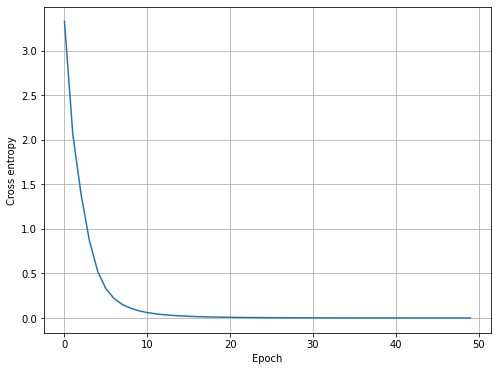

In [18]:
plt.figure(figsize=(8,6))
plt.plot(loss_log[0:])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Cross entropy')

Next, we generate the prediction results based on the trained model:

In [19]:
predictions = my_nn(x_test)

In [20]:
# Get the indices corresponding to the maximum value of each row, as the prediction label
[max_values,indice]=torch.max(predictions.data, 1)

Finally, save the prediction results to CSV

In [21]:
np_prediction=np.asarray(indice.numpy())
y_test_id_np.shape
final=np.vstack((y_test_id_np,np_prediction)).T
final

array([[   1,   15],
       [   2,   10],
       [   3,    6],
       ...,
       [7170,   22],
       [7171,   13],
       [7172,    2]])

In [22]:
# Save as a CSV file
np.savetxt("prediction.csv", final, delimiter=',', header='ID,Category', comments='')